Imports

In [33]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.nn import Module, LSTM, Linear
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, r2_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from transformers import BertTokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Model creation

In [2]:
class Net(Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(Net, self).__init__()
        self.lstm = LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = Linear(hidden_size * 2, num_classes)
        
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

Sentiment Analysis Dataset and declaration

In [29]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        label = self.dataframe.iloc[idx, 0] 
        message = self.dataframe.iloc[idx, 1]  

        encoding = self.tokenizer(
            message,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].float()
        return input_ids, torch.tensor(label, dtype=torch.long)

In [30]:
sentiment_analysis_csv = pd.read_csv('FirstReportData/sentiment_analysis.csv', header=None, encoding='ISO-8859-1')

train_val_data, test_data = train_test_split(sentiment_analysis_csv, test_size=0.2, random_state=42, shuffle=True)
train_data, validation_data = train_test_split(train_val_data, test_size=0.25, random_state=42, shuffle=True)

print("Training data size:", len(train_data))
print("Validation data size:", len(validation_data))
print("Testing data size:", len(test_data))

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
train_dataset = SentimentAnalysisDataset(train_data, tokenizer, max_length=140)
validation_dataset = SentimentAnalysisDataset(validation_data, tokenizer, max_length=140)
test_dataset = SentimentAnalysisDataset(test_data, tokenizer, max_length=140)

Training data size: 960000
Validation data size: 320000
Testing data size: 320000


In [31]:
device = torch.device("mps")

input_size = 140
hidden_size = 128
num_layers = 2
num_classes = 2

# model = Net(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Weather Forecast Dataset and declaration

In [3]:
class WeatherForecastDataset(Dataset):
    def __init__(self, sequence_length=5):
        data = pd.read_csv('FirstReportData/weather_forecast_cleaned.csv')
        data = data.dropna()
        temperatures = data["T (degC)"].values.reshape(-1, 1)
        features = data.drop(columns=["T (degC)"]).values
        
        self.sequences = []
        self.targets = []
        
        for i in range(len(features) - sequence_length):
            self.sequences.append(features[i:i + sequence_length])
            self.targets.append(temperatures[i + sequence_length])
            
        self.sequences = torch.tensor(self.sequences, dtype=torch.float32)
        self.targets = torch.tensor(self.targets, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]


In [22]:
device = torch.device("mps")
weather_forecast_dataset = WeatherForecastDataset(7)

train_val_dataset, test_dataset = train_test_split(weather_forecast_dataset, test_size=0.2, random_state=0, shuffle=False)
train_dataset, validation_dataset = train_test_split(train_val_dataset, test_size=0.25, random_state=0, shuffle=False)

input_size = 11
hidden_size = 64
num_layers = 2
num_classes = 1

model = Net(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Crypto Currency Dataset and declaration

In [3]:
scaler_in = MinMaxScaler(feature_range=(0, 1))
scaler_out = MinMaxScaler(feature_range=(0, 1))
class CryptoDataset(Dataset):
    def __init__(self, data_file, sequence_length=3):
        data = pd.read_csv(data_file) 
        prices = data['Close'].values.reshape(-1, 1)
        features = data.drop(columns=['Date', 'Close', 'Currency']).values

        prices = scaler_out.fit_transform(prices)
        features = scaler_in.fit_transform(features)

        self.sequences = []
        self.targets = []
        for i in range(len(prices) - sequence_length):
            self.sequences.append(features[i:i + sequence_length])
            self.targets.append(prices[i + sequence_length])
            
        self.sequences = torch.tensor(self.sequences, dtype = torch.float32)
        self.targets = torch.tensor(self.targets, dtype = torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

In [10]:
crypto = CryptoDataset('FirstReportData/CryptoCurrencies/Elrond.csv', 14)
train_data, test_data = train_test_split(crypto, test_size=0.2, random_state=0, shuffle=False)
device = torch.device("mps")

input_size = crypto.sequences.shape[2]
hidden_size = 128
num_layers = 2
num_classes = 1

model = Net(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

Urban Sound Dataset and declaration

In [40]:
class UrbanSoundDataset(Dataset):
    def __init__(self, metadata, data_path, fold, test=False, transform=None):
        if test:
            self.metadata = metadata[metadata['fold'] == fold]
        else:
            self.metadata = metadata[metadata['fold'] != fold]
        self.data_path = data_path
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        file_path = os.path.join(self.data_path, f"fold{row['fold']}", row['slice_file_name'])
        label = row['classID']

        # Load audio file using torchaudio
        waveform, sr = torchaudio.load(file_path)

        # Ensure the waveform is a single channel (mono)
        if waveform.size(0) > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Extract MFCC features using torchaudio
        mfcc_transform = torchaudio.transforms.MFCC(
            sample_rate=sr,
            n_mfcc=40,
            melkwargs={"n_fft": 2048, "hop_length": 512, "n_mels": 40}
        )
        mfcc = mfcc_transform(waveform).squeeze(0)  # (n_mfcc, time_frames)

        # Apply any additional transformations
        if self.transform:
            mfcc = self.transform(mfcc)

        # Pad or truncate to a fixed length
        max_length = 325
        if mfcc.size(1) < max_length:
            pad_width = max_length - mfcc.size(1)
            mfcc = torch.nn.functional.pad(mfcc, (0, pad_width))
        else:
            mfcc = mfcc[:, :max_length]

        return mfcc, torch.tensor(label, dtype=torch.long)

Training and evaluation functions

In [45]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)


def evaluate(model, dataloader, criterion, problem_type='classification', plot=False, is_transformed=False, coin_name=""):
    model.eval()
    total_loss = 0

    if problem_type == 'classification':
        correct = 0
    else:
        total_mae_score = 0
        total_r2_score = 0
        
    actuals = []
    predictions = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            if problem_type == 'classification':
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
            else:
                predicted = outputs.squeeze()
                total_mae_score += mean_absolute_error(outputs.cpu(), labels.cpu())
                total_r2_score += r2_score(outputs.cpu(), labels.cpu())
            if is_transformed:
                predicted = scaler_out.inverse_transform(predicted.cpu().numpy().reshape(-1, 1))
                labels = scaler_out.inverse_transform(labels.cpu().numpy().reshape(-1, 1))
            else:
                predicted = predicted.cpu().numpy()
                labels = labels.cpu().numpy()

            predictions.extend(predicted)
            actuals.extend(labels)
            total_loss += loss.item()

    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(actuals, label='Actual Temperatures', color='blue', alpha=0.7)
        plt.plot(predictions, label='Predicted Temperatures', color='orange', linestyle='--', alpha=0.7)
        plt.title(f'{coin_name}Actual vs Predicted Temperatures')
        plt.xlabel('Sample Index')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()

    avg_loss = total_loss / len(dataloader)
    if problem_type == 'classification':
        accuracy = correct / len(dataloader.dataset)
        f1 = f1_score(actuals, predictions, average='weighted')

        cm = confusion_matrix(actuals, predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['air_conditioner', 'car_horn',
                                                                           'children_playing', 'dog_bark', 'drilling',
                                                                           'engine_idling', 'gun_shot',
                                                                           'jackhammer', 'siren', 'street_music'])
        # ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer' 'siren', 'street_music']
        fig, ax = plt.subplots(figsize=(10, 8))
        disp.plot(cmap='Blues', values_format='d', ax=ax)
        ax.tick_params(axis='x', rotation=45)
        plt.title('Confusion Matrix')
        plt.show()

        return avg_loss, accuracy, f1
    else:        
        avg_mae_score = total_mae_score / len(dataloader)
        avg_r2_score = total_r2_score / len(dataloader)
        return avg_loss, avg_mae_score, avg_r2_score


Fold 1
Epoch 1: Train Loss=2.1743, Val Loss=1.9428, Val Acc=0.2405, Val F1=0.1632
Epoch 2: Train Loss=1.8228, Val Loss=1.7324, Val Acc=0.3368, Val F1=0.2988
Epoch 3: Train Loss=1.6213, Val Loss=1.6966, Val Acc=0.3551, Val F1=0.3470
Epoch 4: Train Loss=1.4135, Val Loss=1.7438, Val Acc=0.3333, Val F1=0.3251
Epoch 5: Train Loss=1.1413, Val Loss=1.8857, Val Acc=0.3253, Val F1=0.3138
Epoch 6: Train Loss=0.8777, Val Loss=2.0696, Val Acc=0.3162, Val F1=0.2976
Epoch 7: Train Loss=0.6847, Val Loss=2.2784, Val Acc=0.2955, Val F1=0.2729
Epoch 8: Train Loss=0.5546, Val Loss=2.5116, Val Acc=0.2955, Val F1=0.2797
Epoch 9: Train Loss=0.4575, Val Loss=2.6062, Val Acc=0.3402, Val F1=0.3307
Epoch 10: Train Loss=0.3946, Val Loss=2.7655, Val Acc=0.3127, Val F1=0.3084
Epoch 11: Train Loss=0.2539, Val Loss=2.6797, Val Acc=0.3402, Val F1=0.3331
Epoch 12: Train Loss=0.1619, Val Loss=2.7479, Val Acc=0.3482, Val F1=0.3403
Epoch 13: Train Loss=0.1227, Val Loss=2.8115, Val Acc=0.3471, Val F1=0.3388
Epoch 14: Trai

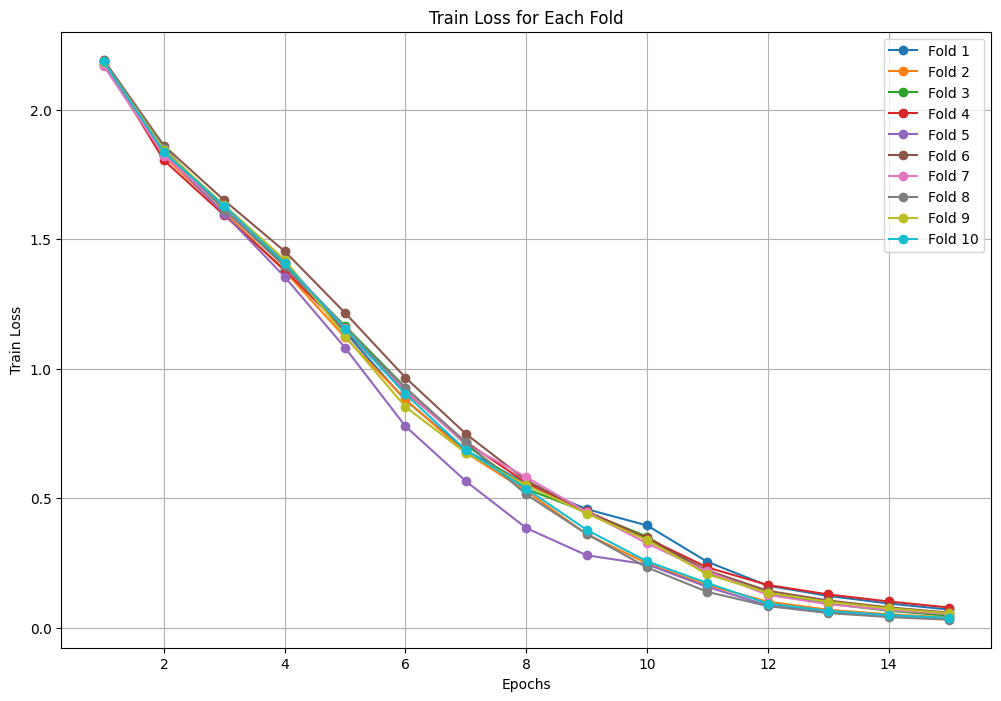

Average Accuracy: 0.3429, Average F1: 0.3435


In [26]:
device = torch.device("mps")

results_acc = []
results_f1 = []

DATA_PATH = 'FirstReportData/urban_sound/'
METADATA_PATH = 'FirstReportData/UrbanSound8K.csv'

metadata = pd.read_csv(METADATA_PATH)

# Dictionary to store train losses for each fold
all_train_losses = {}

for fold in range(10):
    print(f"Fold {fold + 1}")

    train_data = UrbanSoundDataset(metadata, DATA_PATH, fold + 1, test=False)
    val_data = UrbanSoundDataset(metadata, DATA_PATH, fold + 1, test=True)

    train_loader = DataLoader(train_data, batch_size=64, shuffle=False)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

    model = Net(325, 128, 2, 10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)

    train_losses = []  # List to store train losses for the current fold

    for epoch in range(15):
        train_loss = train(model, train_loader, criterion, optimizer)
        val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion)
        scheduler.step()
        train_losses.append(train_loss)  # Store train loss for the current epoch

        print(
            f"Epoch {epoch + 1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}")

    all_train_losses[f"Fold {fold + 1}"] = train_losses  # Store losses for this fold
    results_acc.append(val_acc)
    results_f1.append(val_f1)

# Plot all train losses from each fold
plt.figure(figsize=(12, 8))
for fold, losses in all_train_losses.items():
    plt.plot(range(1, 16), losses, label=fold, marker='o')

plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('Train Loss for Each Fold')
plt.legend()
plt.grid(True)
plt.show()

print(
    f"Average Accuracy: {sum(results_acc) / len(results_acc):.4f}, Average F1: {sum(results_f1) / len(results_f1):.4f}")
torch.save(model.state_dict(), 'urban_sound.pth')

/var/folders/gg/xybng_gj2rz3ltl94z9r_c59xzqsfn/T/ipykernel_51804/3344044039.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weather.pt

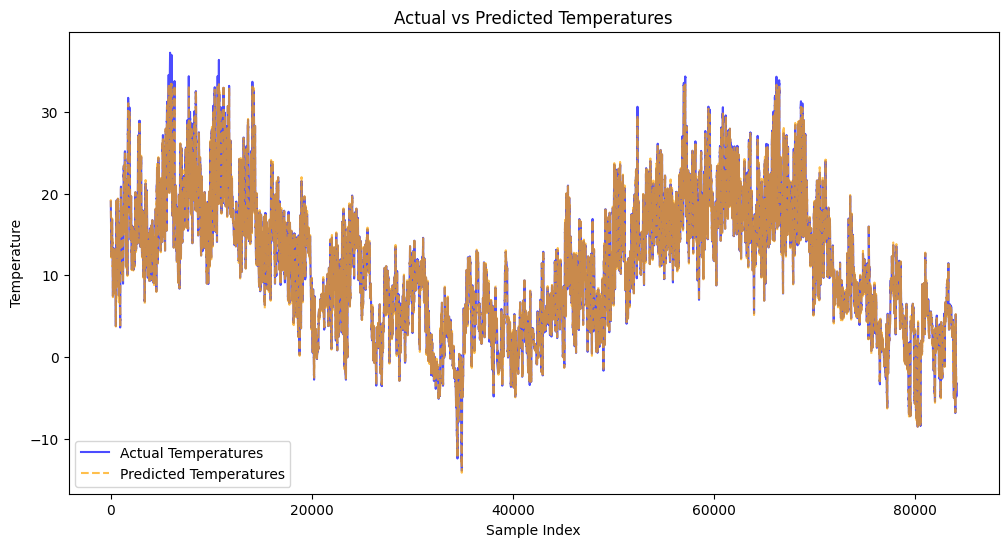

Test Loss: 0.0954, Test Accuracy: 0.2104, Test r2: -0.9070


In [25]:
num_epochs = 30

# train_losses = []
# validation_losses = []
#
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# for epoch in range(num_epochs):
#     train_loss = train(model, train_dataloader, criterion, optimizer)
#     validation_loss, validation_accuracy, validation_r2 = evaluate(model, validation_dataloader, criterion, "regression",
#                                                     plot=False)
#     scheduler.step()
#     train_losses.append(train_loss)
#     validation_losses.append(validation_loss)
#
#     print(
#         f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {validation_loss:.4f}, Val Accuracy: {validation_accuracy:.4f}, Val r2: {validation_r2:.4f}')
#
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
# plt.plot(range(1, num_epochs + 1), validation_losses, label='Val Loss', marker='s')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Train Loss vs Val Loss')
# plt.legend()
# plt.grid(True)
# plt.show()

model = Net(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device)
model.load_state_dict(torch.load('weather.pth'))

test_loss, test_accuracy, test_r2 = evaluate(model, test_dataloader, criterion, "regression", True)
print(
    f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test r2: {test_r2:.4f}')
# torch.save(model.state_dict(), 'weather.pth')

Epoch [1/60], Train Loss: 0.0011, Val Loss: 0.1414, Val Accuracy: 0.3020, Val r2: -37595.1308
Epoch [2/60], Train Loss: 0.0024, Val Loss: 0.1808, Val Accuracy: 0.3545, Val r2: -35077.5041
Epoch [3/60], Train Loss: 0.0018, Val Loss: 0.1429, Val Accuracy: 0.3083, Val r2: -7980.0833
Epoch [4/60], Train Loss: 0.0019, Val Loss: 0.1321, Val Accuracy: 0.2964, Val r2: -4697.5703
Epoch [5/60], Train Loss: 0.0018, Val Loss: 0.1100, Val Accuracy: 0.2712, Val r2: -1666.7158
Epoch [6/60], Train Loss: 0.0015, Val Loss: 0.0527, Val Accuracy: 0.1894, Val r2: -227.2162
Epoch [7/60], Train Loss: 0.0011, Val Loss: 0.0033, Val Accuracy: 0.0468, Val r2: -17.2769
Epoch [8/60], Train Loss: 0.0006, Val Loss: 0.1051, Val Accuracy: 0.2610, Val r2: -238.1099
Epoch [9/60], Train Loss: 0.0002, Val Loss: 0.1174, Val Accuracy: 0.2758, Val r2: -217.4003
Epoch [10/60], Train Loss: 0.0001, Val Loss: 0.0258, Val Accuracy: 0.1226, Val r2: -24.1563
Epoch [11/60], Train Loss: 0.0002, Val Loss: 0.0619, Val Accuracy: 0.1981,

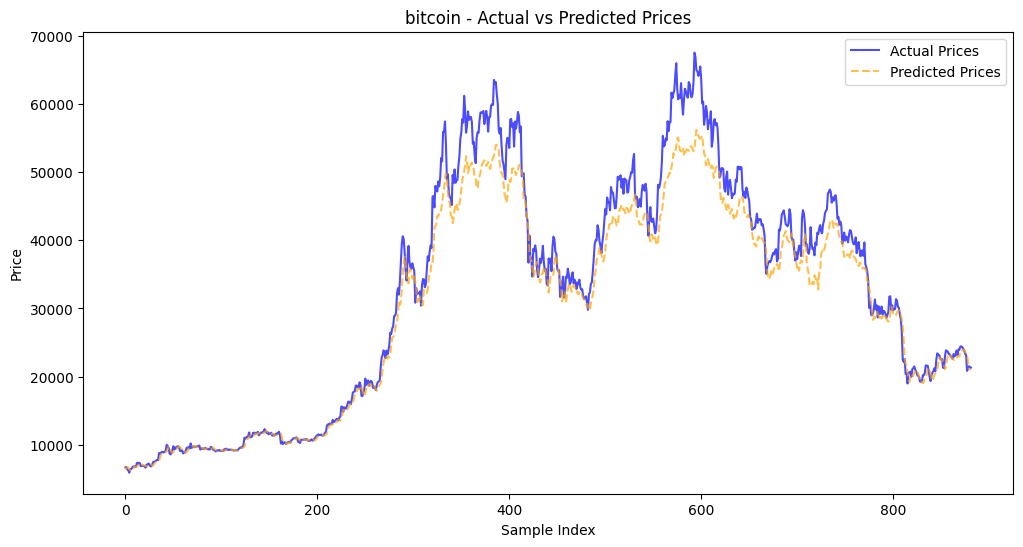

Epoch [1/60], Train Loss: 0.0368, Val Loss: 0.0377, Val Accuracy: 0.1455, Val r2: -4669.8350
Epoch [2/60], Train Loss: 0.0499, Val Loss: 0.0510, Val Accuracy: 0.1793, Val r2: -1104.4662
Epoch [3/60], Train Loss: 0.0083, Val Loss: 0.0033, Val Accuracy: 0.0508, Val r2: -12.9196
Epoch [4/60], Train Loss: 0.0149, Val Loss: 0.0138, Val Accuracy: 0.0889, Val r2: -85.9108
Epoch [5/60], Train Loss: 0.0075, Val Loss: 0.0173, Val Accuracy: 0.1285, Val r2: -73.8782
Epoch [6/60], Train Loss: 0.0095, Val Loss: 0.0048, Val Accuracy: 0.0513, Val r2: -18.9133
Epoch [7/60], Train Loss: 0.0053, Val Loss: 0.0087, Val Accuracy: 0.0894, Val r2: -35.1032
Epoch [8/60], Train Loss: 0.0135, Val Loss: 0.0147, Val Accuracy: 0.0912, Val r2: -86.3407
Epoch [9/60], Train Loss: 0.0035, Val Loss: 0.0014, Val Accuracy: 0.0324, Val r2: -4.1172
Epoch [10/60], Train Loss: 0.0032, Val Loss: 0.0016, Val Accuracy: 0.0278, Val r2: -3.9246
Epoch [11/60], Train Loss: 0.0010, Val Loss: 0.0007, Val Accuracy: 0.0197, Val r2: -0.4

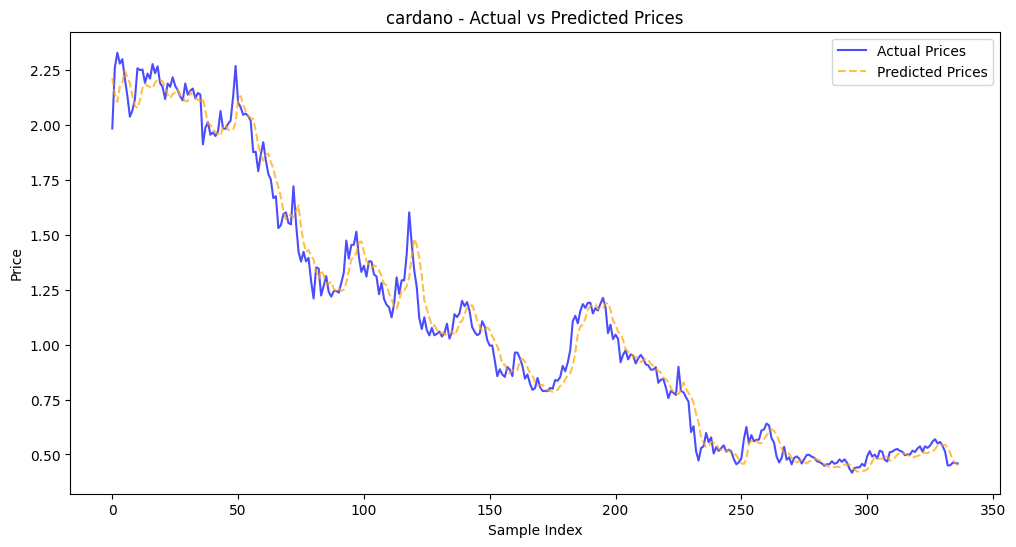

Epoch [1/60], Train Loss: 0.0152, Val Loss: 0.0235, Val Accuracy: 0.1190, Val r2: -21191.7530
Epoch [2/60], Train Loss: 0.0169, Val Loss: 0.0244, Val Accuracy: 0.1282, Val r2: -2001.1069
Epoch [3/60], Train Loss: 0.0077, Val Loss: 0.0029, Val Accuracy: 0.0447, Val r2: -16.0401
Epoch [4/60], Train Loss: 0.1066, Val Loss: 0.0046, Val Accuracy: 0.0624, Val r2: -140.9487
Epoch [5/60], Train Loss: 0.0138, Val Loss: 0.0384, Val Accuracy: 0.1731, Val r2: -6178.8466
Epoch [6/60], Train Loss: 0.0119, Val Loss: 0.0308, Val Accuracy: 0.1555, Val r2: -1827.2921
Epoch [7/60], Train Loss: 0.0085, Val Loss: 0.0189, Val Accuracy: 0.1220, Val r2: -420.8671
Epoch [8/60], Train Loss: 0.0027, Val Loss: 0.0005, Val Accuracy: 0.0144, Val r2: -0.9608
Epoch [9/60], Train Loss: 0.0039, Val Loss: 0.0010, Val Accuracy: 0.0279, Val r2: -27.5203
Epoch [10/60], Train Loss: 0.0066, Val Loss: 0.0148, Val Accuracy: 0.1074, Val r2: -254.1066
Epoch [11/60], Train Loss: 0.0048, Val Loss: 0.0112, Val Accuracy: 0.0945, Val

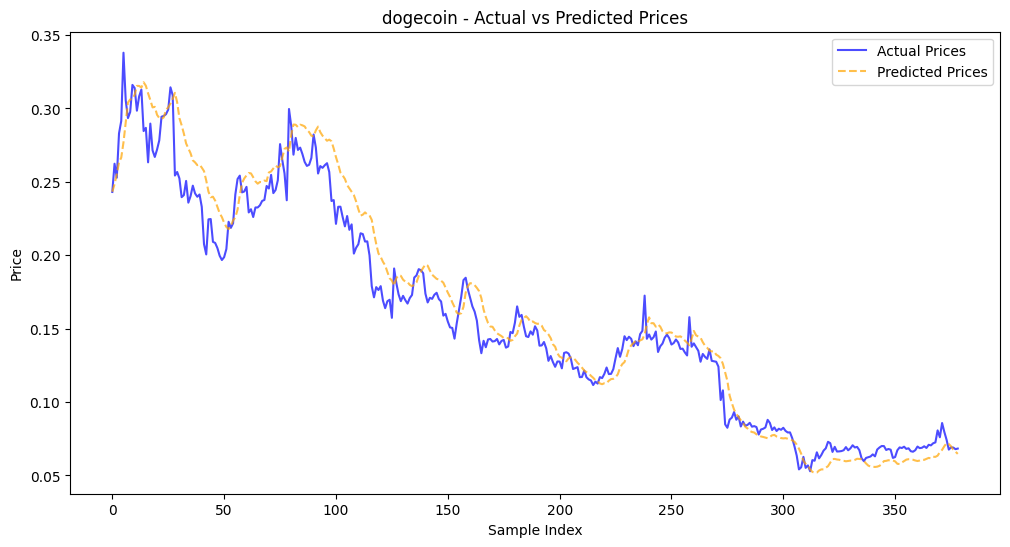

Epoch [1/60], Train Loss: 0.0296, Val Loss: 0.1211, Val Accuracy: 0.3421, Val r2: -53632.3409
Epoch [2/60], Train Loss: 0.0705, Val Loss: 0.0051, Val Accuracy: 0.0663, Val r2: -1827.5420
Epoch [3/60], Train Loss: 0.0199, Val Loss: 0.0240, Val Accuracy: 0.1484, Val r2: -2064.0310
Epoch [4/60], Train Loss: 0.0190, Val Loss: 0.0058, Val Accuracy: 0.0729, Val r2: -213.6501
Epoch [5/60], Train Loss: 0.0063, Val Loss: 0.0017, Val Accuracy: 0.0381, Val r2: -33.3839
Epoch [6/60], Train Loss: 0.0029, Val Loss: 0.0048, Val Accuracy: 0.0678, Val r2: -95.4121
Epoch [7/60], Train Loss: 0.0036, Val Loss: 0.0006, Val Accuracy: 0.0184, Val r2: -2.3933
Epoch [8/60], Train Loss: 0.0023, Val Loss: 0.0007, Val Accuracy: 0.0248, Val r2: -13.0106
Epoch [9/60], Train Loss: 0.0023, Val Loss: 0.0034, Val Accuracy: 0.0561, Val r2: -48.9455
Epoch [10/60], Train Loss: 0.0027, Val Loss: 0.0006, Val Accuracy: 0.0169, Val r2: -0.7121
Epoch [11/60], Train Loss: 0.0018, Val Loss: 0.0003, Val Accuracy: 0.0127, Val r2: 

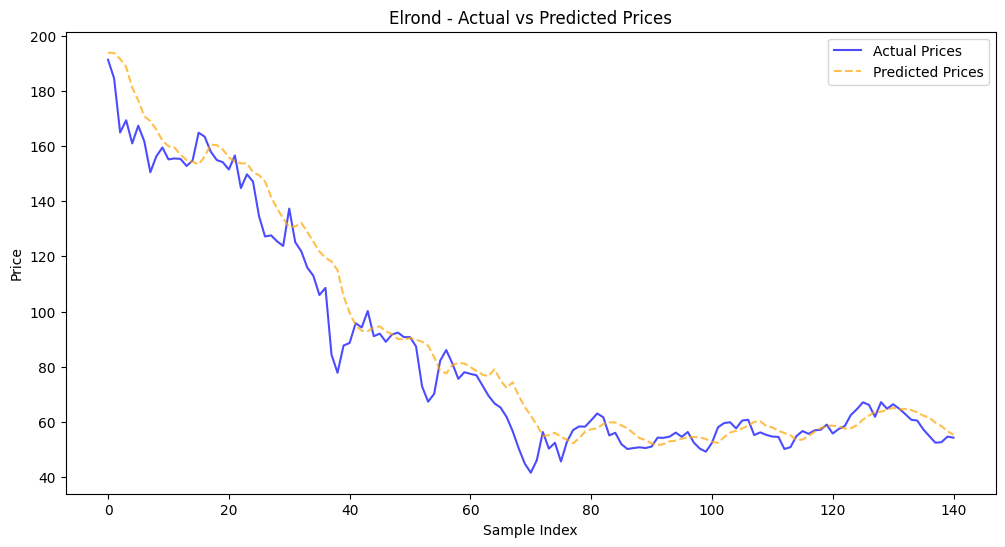

Epoch [1/60], Train Loss: 0.0113, Val Loss: 0.2189, Val Accuracy: 0.4290, Val r2: -91971.8187
Epoch [2/60], Train Loss: 0.0148, Val Loss: 0.2016, Val Accuracy: 0.4180, Val r2: -4359.4113
Epoch [3/60], Train Loss: 0.0026, Val Loss: 0.0231, Val Accuracy: 0.1365, Val r2: -22.2441
Epoch [4/60], Train Loss: 0.0092, Val Loss: 0.1424, Val Accuracy: 0.3522, Val r2: -871.5831
Epoch [5/60], Train Loss: 0.0016, Val Loss: 0.0082, Val Accuracy: 0.0739, Val r2: -4.0877
Epoch [6/60], Train Loss: 0.0017, Val Loss: 0.0033, Val Accuracy: 0.0448, Val r2: -0.6975
Epoch [7/60], Train Loss: 0.0012, Val Loss: 0.0352, Val Accuracy: 0.1509, Val r2: -9.2713
Epoch [8/60], Train Loss: 0.0029, Val Loss: 0.0177, Val Accuracy: 0.1210, Val r2: -16.7323
Epoch [9/60], Train Loss: 0.0014, Val Loss: 0.0156, Val Accuracy: 0.1042, Val r2: -5.5204
Epoch [10/60], Train Loss: 0.0050, Val Loss: 0.0761, Val Accuracy: 0.2558, Val r2: -178.9299
Epoch [11/60], Train Loss: 0.0025, Val Loss: 0.0351, Val Accuracy: 0.1712, Val r2: -48

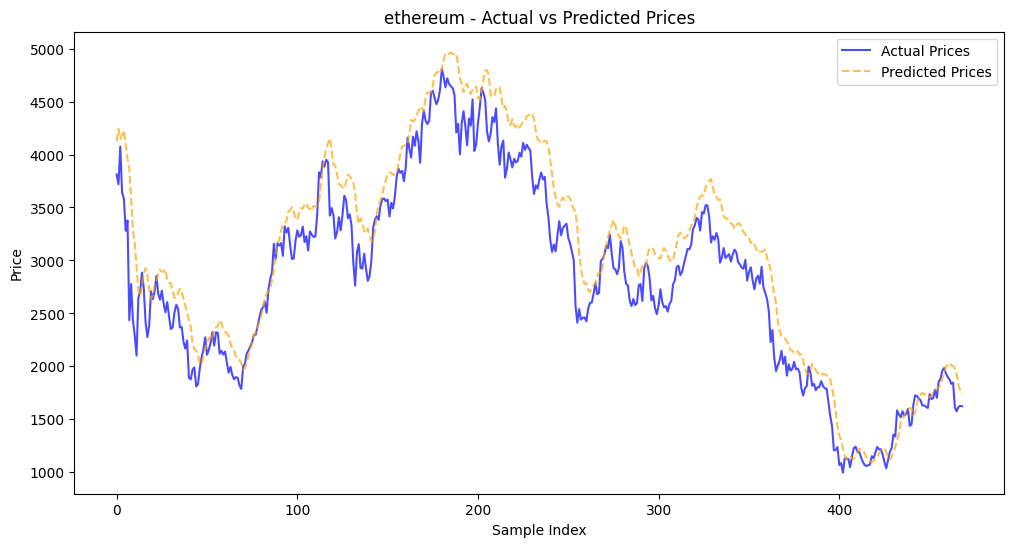

Epoch [1/60], Train Loss: 0.0324, Val Loss: 0.0279, Val Accuracy: 0.1357, Val r2: -1270.0418
Epoch [2/60], Train Loss: 0.0107, Val Loss: 0.0039, Val Accuracy: 0.0486, Val r2: -9.9795
Epoch [3/60], Train Loss: 0.0065, Val Loss: 0.0012, Val Accuracy: 0.0282, Val r2: -8.5026
Epoch [4/60], Train Loss: 0.0021, Val Loss: 0.0008, Val Accuracy: 0.0191, Val r2: -0.3049
Epoch [5/60], Train Loss: 0.0025, Val Loss: 0.0008, Val Accuracy: 0.0215, Val r2: -1.7611
Epoch [6/60], Train Loss: 0.0026, Val Loss: 0.0010, Val Accuracy: 0.0244, Val r2: -2.4922
Epoch [7/60], Train Loss: 0.0023, Val Loss: 0.0012, Val Accuracy: 0.0274, Val r2: -2.6158
Epoch [8/60], Train Loss: 0.0020, Val Loss: 0.0014, Val Accuracy: 0.0298, Val r2: -2.5455
Epoch [9/60], Train Loss: 0.0016, Val Loss: 0.0015, Val Accuracy: 0.0312, Val r2: -2.3153
Epoch [10/60], Train Loss: 0.0012, Val Loss: 0.0015, Val Accuracy: 0.0317, Val r2: -2.0550
Epoch [11/60], Train Loss: 0.0010, Val Loss: 0.0008, Val Accuracy: 0.0209, Val r2: -0.3056
Epoch

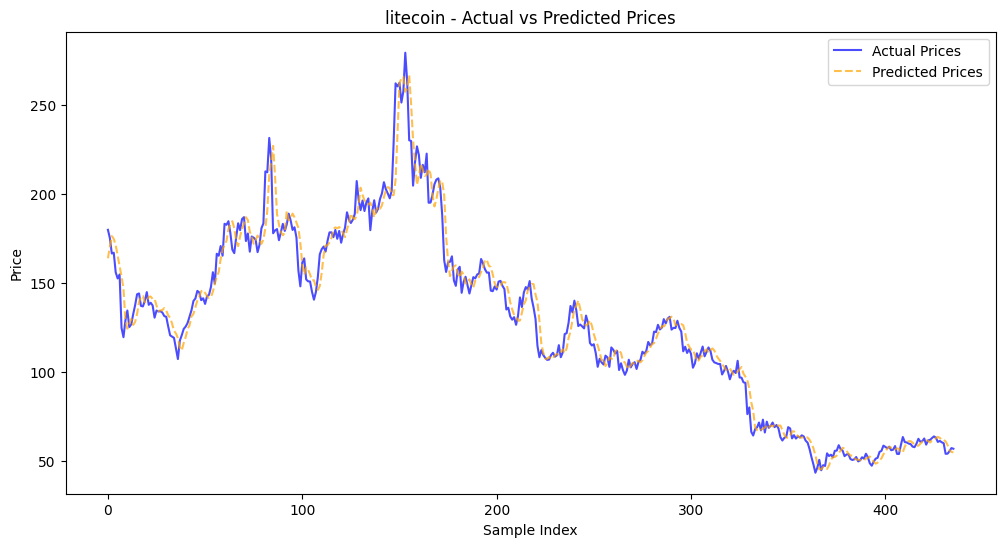

Epoch [1/60], Train Loss: 0.0803, Val Loss: 0.1675, Val Accuracy: 0.4053, Val r2: -14006.5075
Epoch [2/60], Train Loss: 0.0761, Val Loss: 0.0242, Val Accuracy: 0.1450, Val r2: -2089.2704
Epoch [3/60], Train Loss: 0.0262, Val Loss: 0.0486, Val Accuracy: 0.2175, Val r2: -1066.1758
Epoch [4/60], Train Loss: 0.0199, Val Loss: 0.0114, Val Accuracy: 0.1040, Val r2: -170.9780
Epoch [5/60], Train Loss: 0.0076, Val Loss: 0.0008, Val Accuracy: 0.0236, Val r2: -7.2291
Epoch [6/60], Train Loss: 0.0058, Val Loss: 0.0013, Val Accuracy: 0.0331, Val r2: -11.9956
Epoch [7/60], Train Loss: 0.0050, Val Loss: 0.0009, Val Accuracy: 0.0263, Val r2: -6.6440
Epoch [8/60], Train Loss: 0.0036, Val Loss: 0.0005, Val Accuracy: 0.0168, Val r2: -1.7169
Epoch [9/60], Train Loss: 0.0032, Val Loss: 0.0004, Val Accuracy: 0.0160, Val r2: -1.2141
Epoch [10/60], Train Loss: 0.0032, Val Loss: 0.0005, Val Accuracy: 0.0175, Val r2: -1.4625
Epoch [11/60], Train Loss: 0.0030, Val Loss: 0.0006, Val Accuracy: 0.0202, Val r2: -1.

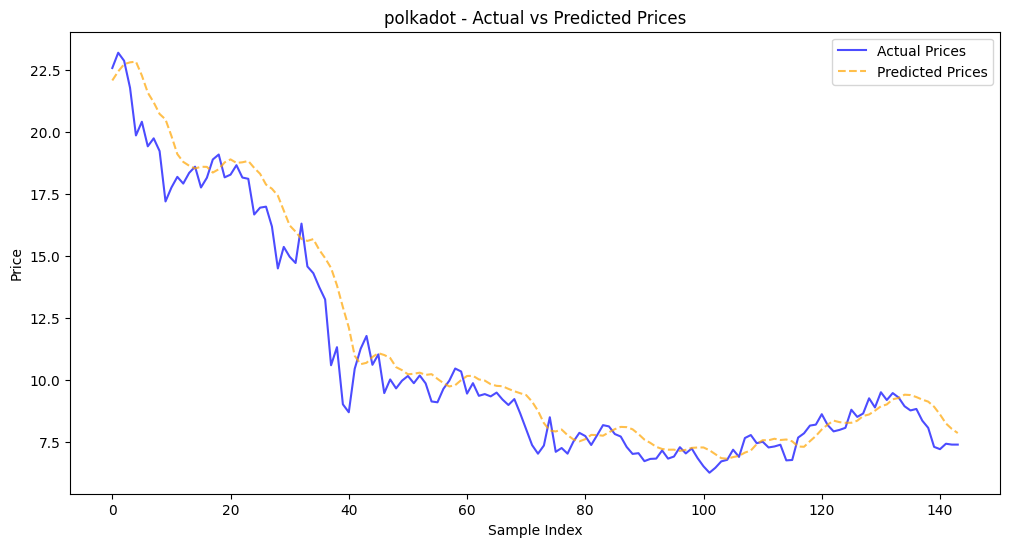

Epoch [1/60], Train Loss: 0.0193, Val Loss: 0.1305, Val Accuracy: 0.3161, Val r2: -12696.9769
Epoch [2/60], Train Loss: 0.0209, Val Loss: 0.1144, Val Accuracy: 0.2954, Val r2: -2008.5909
Epoch [3/60], Train Loss: 0.0158, Val Loss: 0.0974, Val Accuracy: 0.2730, Val r2: -550.4318
Epoch [4/60], Train Loss: 0.0089, Val Loss: 0.0485, Val Accuracy: 0.1830, Val r2: -59.1512
Epoch [5/60], Train Loss: 0.0029, Val Loss: 0.0062, Val Accuracy: 0.0558, Val r2: -0.8376
Epoch [6/60], Train Loss: 0.0026, Val Loss: 0.0053, Val Accuracy: 0.0525, Val r2: -0.7999
Epoch [7/60], Train Loss: 0.0066, Val Loss: 0.0407, Val Accuracy: 0.1708, Val r2: -33.3780
Epoch [8/60], Train Loss: 0.0024, Val Loss: 0.0119, Val Accuracy: 0.0750, Val r2: -2.0788
Epoch [9/60], Train Loss: 0.0019, Val Loss: 0.0066, Val Accuracy: 0.0573, Val r2: -0.6398
Epoch [10/60], Train Loss: 0.0017, Val Loss: 0.0046, Val Accuracy: 0.0492, Val r2: -0.8864
Epoch [11/60], Train Loss: 0.0010, Val Loss: 0.0075, Val Accuracy: 0.0609, Val r2: -0.77

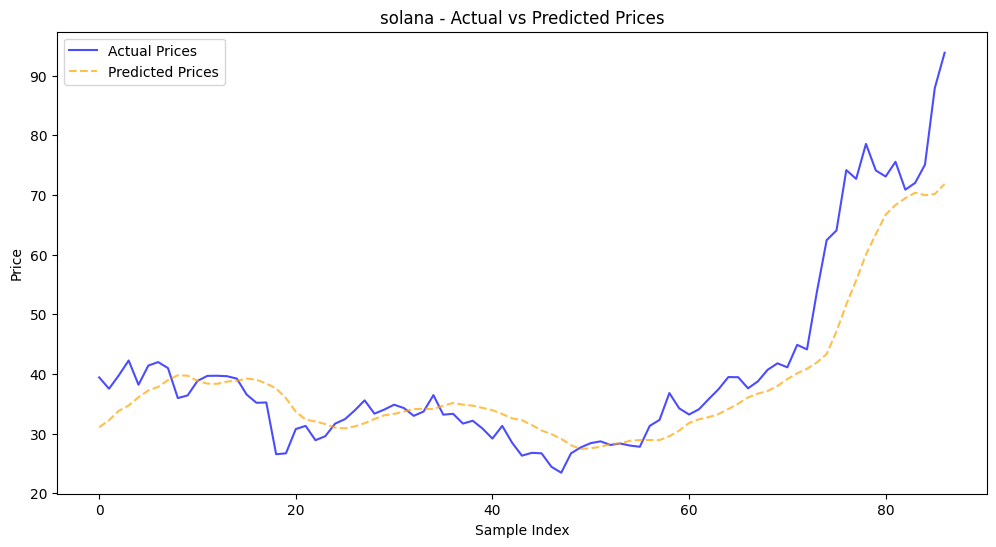

Epoch [1/60], Train Loss: 0.0366, Val Loss: 0.0250, Val Accuracy: 0.1294, Val r2: -3393.1529
Epoch [2/60], Train Loss: 0.0163, Val Loss: 0.0017, Val Accuracy: 0.0313, Val r2: -9.8338
Epoch [3/60], Train Loss: 0.0175, Val Loss: 0.0092, Val Accuracy: 0.0750, Val r2: -139.0122
Epoch [4/60], Train Loss: 0.0051, Val Loss: 0.0004, Val Accuracy: 0.0142, Val r2: -0.4872
Epoch [5/60], Train Loss: 0.0016, Val Loss: 0.0004, Val Accuracy: 0.0143, Val r2: -0.4199
Epoch [6/60], Train Loss: 0.0013, Val Loss: 0.0004, Val Accuracy: 0.0145, Val r2: -0.5469
Epoch [7/60], Train Loss: 0.0013, Val Loss: 0.0004, Val Accuracy: 0.0140, Val r2: -0.1757
Epoch [8/60], Train Loss: 0.0012, Val Loss: 0.0004, Val Accuracy: 0.0139, Val r2: -0.1735
Epoch [9/60], Train Loss: 0.0012, Val Loss: 0.0004, Val Accuracy: 0.0136, Val r2: -0.0505
Epoch [10/60], Train Loss: 0.0011, Val Loss: 0.0004, Val Accuracy: 0.0134, Val r2: -0.0072
Epoch [11/60], Train Loss: 0.0011, Val Loss: 0.0005, Val Accuracy: 0.0175, Val r2: -2.7854
Epo

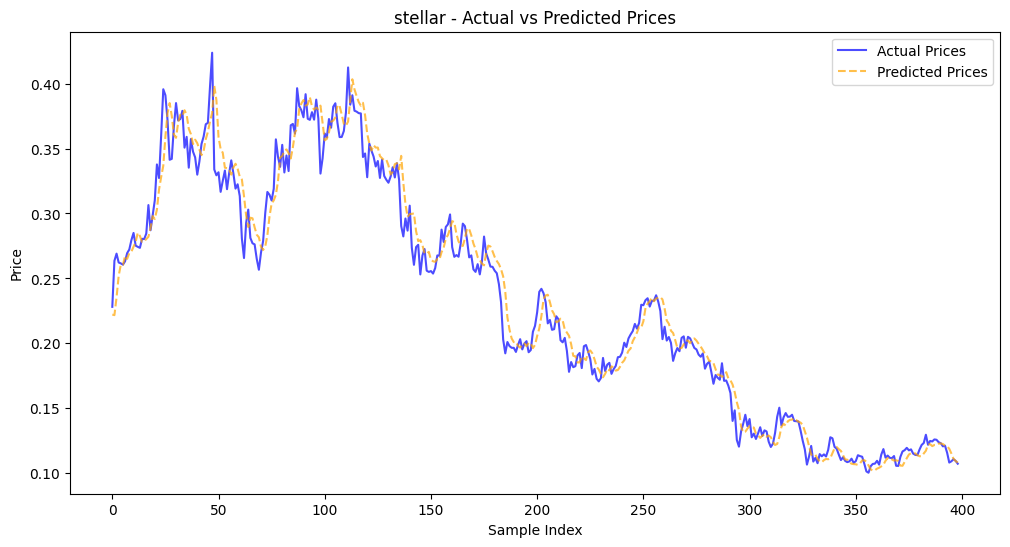

Epoch [1/60], Train Loss: 0.0732, Val Loss: 0.0001, Val Accuracy: 0.0071, Val r2: -428.0363
Epoch [2/60], Train Loss: 0.0035, Val Loss: 0.0003, Val Accuracy: 0.0167, Val r2: -686.3906
Epoch [3/60], Train Loss: 0.0033, Val Loss: 0.0001, Val Accuracy: 0.0109, Val r2: -587.7876
Epoch [4/60], Train Loss: 0.0031, Val Loss: 0.0000, Val Accuracy: 0.0059, Val r2: -20.7386
Epoch [5/60], Train Loss: 0.0030, Val Loss: 0.0001, Val Accuracy: 0.0056, Val r2: -7.1780
Epoch [6/60], Train Loss: 0.0029, Val Loss: 0.0001, Val Accuracy: 0.0062, Val r2: -5.2350
Epoch [7/60], Train Loss: 0.0029, Val Loss: 0.0001, Val Accuracy: 0.0067, Val r2: -4.6208
Epoch [8/60], Train Loss: 0.0029, Val Loss: 0.0001, Val Accuracy: 0.0068, Val r2: -4.1478
Epoch [9/60], Train Loss: 0.0028, Val Loss: 0.0001, Val Accuracy: 0.0066, Val r2: -3.6334
Epoch [10/60], Train Loss: 0.0028, Val Loss: 0.0001, Val Accuracy: 0.0063, Val r2: -3.0930
Epoch [11/60], Train Loss: 0.0026, Val Loss: 0.0001, Val Accuracy: 0.0061, Val r2: -1.3333
E

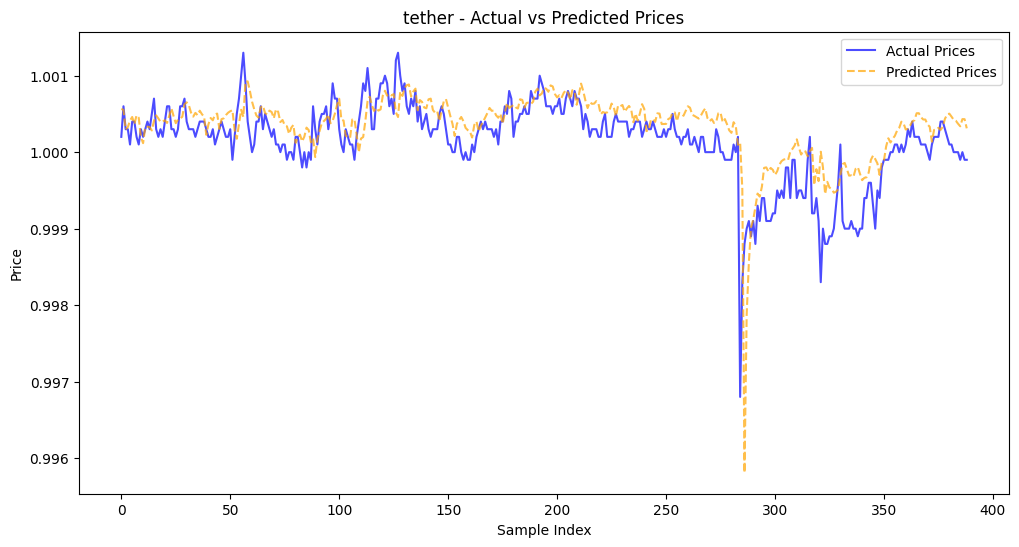

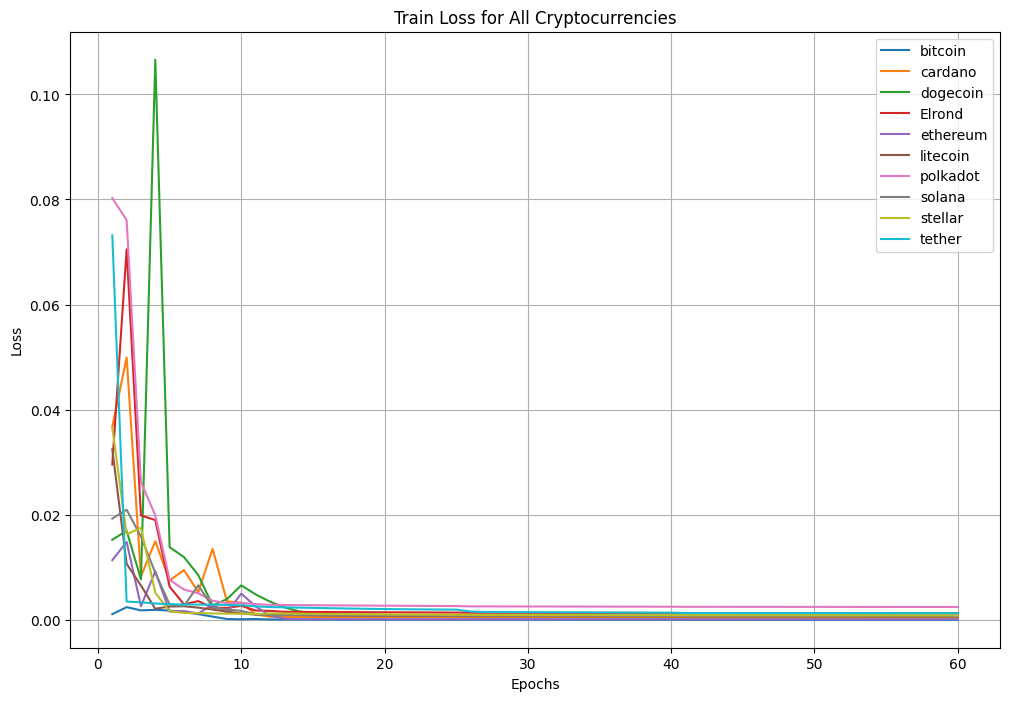

Average MAE: 0.0237, Average R2: -1.6448


In [67]:
coins = ['bitcoin', 'cardano', 'dogecoin', 'Elrond', 'ethereum', 'litecoin', 'polkadot', 'solana', 'stellar', 'tether']
all_train_losses = {}
# coins = ['Elrond']

results_mae = []
results_r2 = []

for coin in coins:
    crypto = CryptoDataset(f'FirstReportData/CryptoCurrencies/{coin}.csv', 14)
    train_data, test_data = train_test_split(crypto, test_size=0.2, random_state=0, shuffle=False)
    device = torch.device("mps")

    input_size = crypto.sequences.shape[2]
    hidden_size = 64
    num_layers = 2
    num_classes = 1

    model = Net(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_dataloader = DataLoader(train_data, batch_size=32, shuffle=False)
    test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

    num_epochs = 60

    train_losses = []

    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 25, 40], gamma=0.3)
    for epoch in range(num_epochs):
        train_loss = train(model, train_dataloader, criterion, optimizer)
        test_loss, test_accuracy, test_r2  = evaluate(model, test_dataloader, criterion, "regression", plot=False)
        scheduler.step()
        train_losses.append(train_loss)

        print(
            f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {test_loss:.4f}, Val Accuracy: {test_accuracy:.4f}, Val r2: {test_r2:.4f}')
    all_train_losses[coin] = train_losses
    results_mae.append(test_accuracy)
    results_r2.append(test_r2)
    evaluate(model, test_dataloader, criterion, "regression", plot=True, is_transformed=True, coin_name=coin)

# Plot all train losses on the same figure
plt.figure(figsize=(12, 8))
for coin, losses in all_train_losses.items():
    plt.plot(range(1, num_epochs + 1), losses, label=coin)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss for All Cryptocurrencies')
plt.legend()
plt.grid(True)
plt.show()

print(f"Average MAE: {sum(results_mae) / len(results_mae):.4f}, Average R2: {sum(results_r2) / len(results_r2):.4f}")

Epoch [1/25], Train Loss: 0.0872, Test Loss: 0.0140, Test Accuracy: 0.0865
Epoch [2/25], Train Loss: 0.0712, Test Loss: 0.0088, Test Accuracy: 0.0588
Epoch [3/25], Train Loss: 0.0575, Test Loss: 0.0064, Test Accuracy: 0.0630
Epoch [4/25], Train Loss: 0.0463, Test Loss: 0.0071, Test Accuracy: 0.0775
Epoch [5/25], Train Loss: 0.0383, Test Loss: 0.0105, Test Accuracy: 0.0965
Epoch [6/25], Train Loss: 0.0338, Test Loss: 0.0154, Test Accuracy: 0.1141
Epoch [7/25], Train Loss: 0.0323, Test Loss: 0.0193, Test Accuracy: 0.1259
Epoch [8/25], Train Loss: 0.0318, Test Loss: 0.0210, Test Accuracy: 0.1307
Epoch [9/25], Train Loss: 0.0313, Test Loss: 0.0211, Test Accuracy: 0.1308
Epoch [10/25], Train Loss: 0.0303, Test Loss: 0.0205, Test Accuracy: 0.1289
Epoch [11/25], Train Loss: 0.0291, Test Loss: 0.0198, Test Accuracy: 0.1266
Epoch [12/25], Train Loss: 0.0277, Test Loss: 0.0192, Test Accuracy: 0.1246
Epoch [13/25], Train Loss: 0.0262, Test Loss: 0.0185, Test Accuracy: 0.1227
Epoch [14/25], Train 

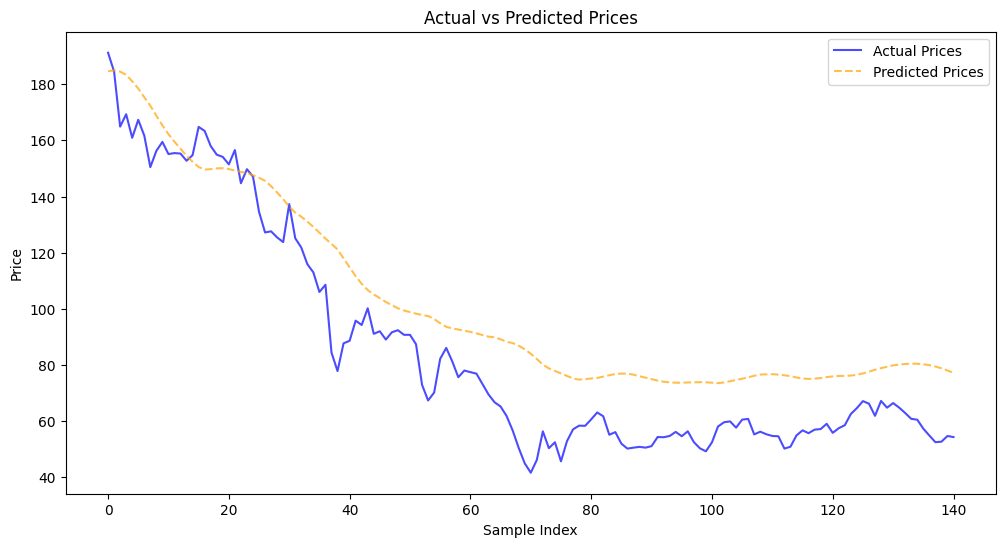

(0.0016055703939249117, np.float32(0.03623356))

In [14]:
#  Average MAE: 0.0237, Average R2: -1.6448
num_epochs = 30
for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, criterion, optimizer)
    test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, "regression", plot=False, is_transformed=True)

    print(
        f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

evaluate(model, test_dataloader, criterion, "regression", plot=True, is_transformed=True)


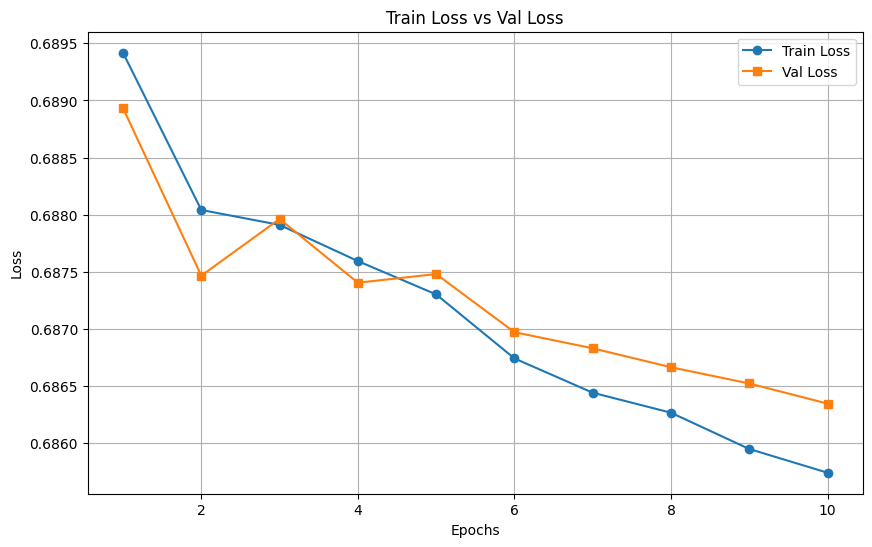

Test Loss: 0.6860, Test Accuracy: 0.5507, Test F1: 0.5502


In [14]:
num_epochs = 10

# train_losses = []
# validation_losses = []

# optimizer = optim.Adam(model.parameters(), lr=0.0001)
# for epoch in range(num_epochs):
#     train_loss = train(model, train_dataloader, criterion, optimizer)
#     validation_loss, validation_accuracy, validation_f1 = evaluate(model, validation_dataloader, criterion)
#
#     train_losses.append(train_loss)
#     validation_losses.append(validation_loss)
#
#     print(
#         f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {validation_loss:.4f}, Val Accuracy: {validation_accuracy:.4f}, val F1: {validation_f1:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Val Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Val Loss')
plt.legend()
plt.grid(True)
plt.show()

test_loss, test_accuracy, test_f1 = evaluate(model, test_dataloader, criterion)
print(
    f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1: {test_f1:.4f}')


/var/folders/gg/xybng_gj2rz3ltl94z9r_c59xzqsfn/T/ipykernel_51804/1767997745.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('sentiment_a

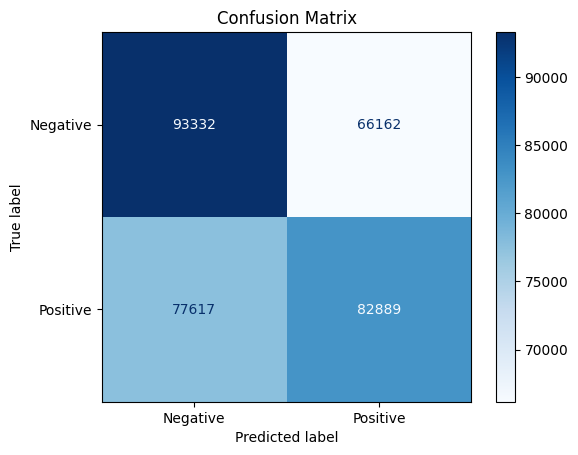

Test Loss: 0.6860, Test Accuracy: 0.5507, Test F1: 0.5502


In [38]:
# save the model
# Test Loss: 0.6872, Test Accuracy: 0.5467, Test F1: 0.5443
# Test Loss: 0.6860, Test Accuracy: 0.5507, Test F1: 0.5502
# torch.save(model.state_dict(), 'sentiment_analysis_2.pth')
# load the model, and make the confusion matrix when evaluation the model
model = Net(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device)
model.load_state_dict(torch.load('sentiment_analysis_2.pth'))

test_loss, test_accuracy, test_f1 = evaluate(model, test_dataloader, criterion)
print(
    f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1: {test_f1:.4f}')

/var/folders/gg/xybng_gj2rz3ltl94z9r_c59xzqsfn/T/ipykernel_51804/4157235618.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('urban_sound

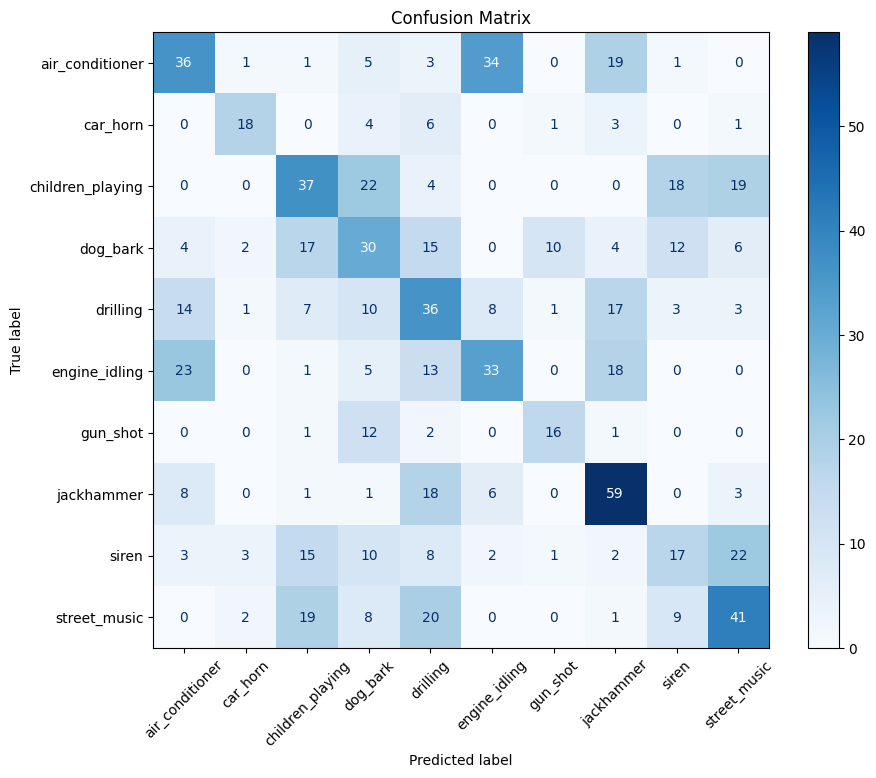

Test Loss: 2.7381, Test Accuracy: 0.3859, Test F1: 0.3838


In [46]:
# do the same for urban sound

model = Net(325, 128, 2, 10).to(device)
model.load_state_dict(torch.load('urban_sound.pth'))

test_data = UrbanSoundDataset(metadata, DATA_PATH, 10, test=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

test_loss, test_accuracy, test_f1 = evaluate(model, test_dataloader, criterion, "classification")
print(
    f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1: {test_f1:.4f}')

Manual testing

In [79]:
# torch.save(model.state_dict(), 'FirstReportData/sentiment_analysis_model.pth')

model = Net(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device)
model.load_state_dict(torch.load('FirstReportData/sentiment_analysis_model.pth'))
model.eval()
message = "i loved it here"
encoding = tokenizer(
    message,
    add_special_tokens=True,
    max_length=140,
    padding='max_length',
    truncation=False,
    return_tensors='pt'
)

output = model(encoding['input_ids'].float().to(device))
_, predicted = torch.max(output, 1)
print("Predicted:", predicted.item())


Predicted: 0


/var/folders/gg/xybng_gj2rz3ltl94z9r_c59xzqsfn/T/ipykernel_59828/1505535154.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('FirstReport

In [19]:
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion)

print(
    f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.0836, Test Accuracy: 0.2891


0.0
0.0
T (degC)
rh (%)
VPmax (mbar)
VPact (mbar)
VPdef (mbar)
sh (g/kg)
H2OC (mmol/mol)
rho (g/m**3)
wv (m/s)
max. wv (m/s)
wd (deg)
p (mbar)


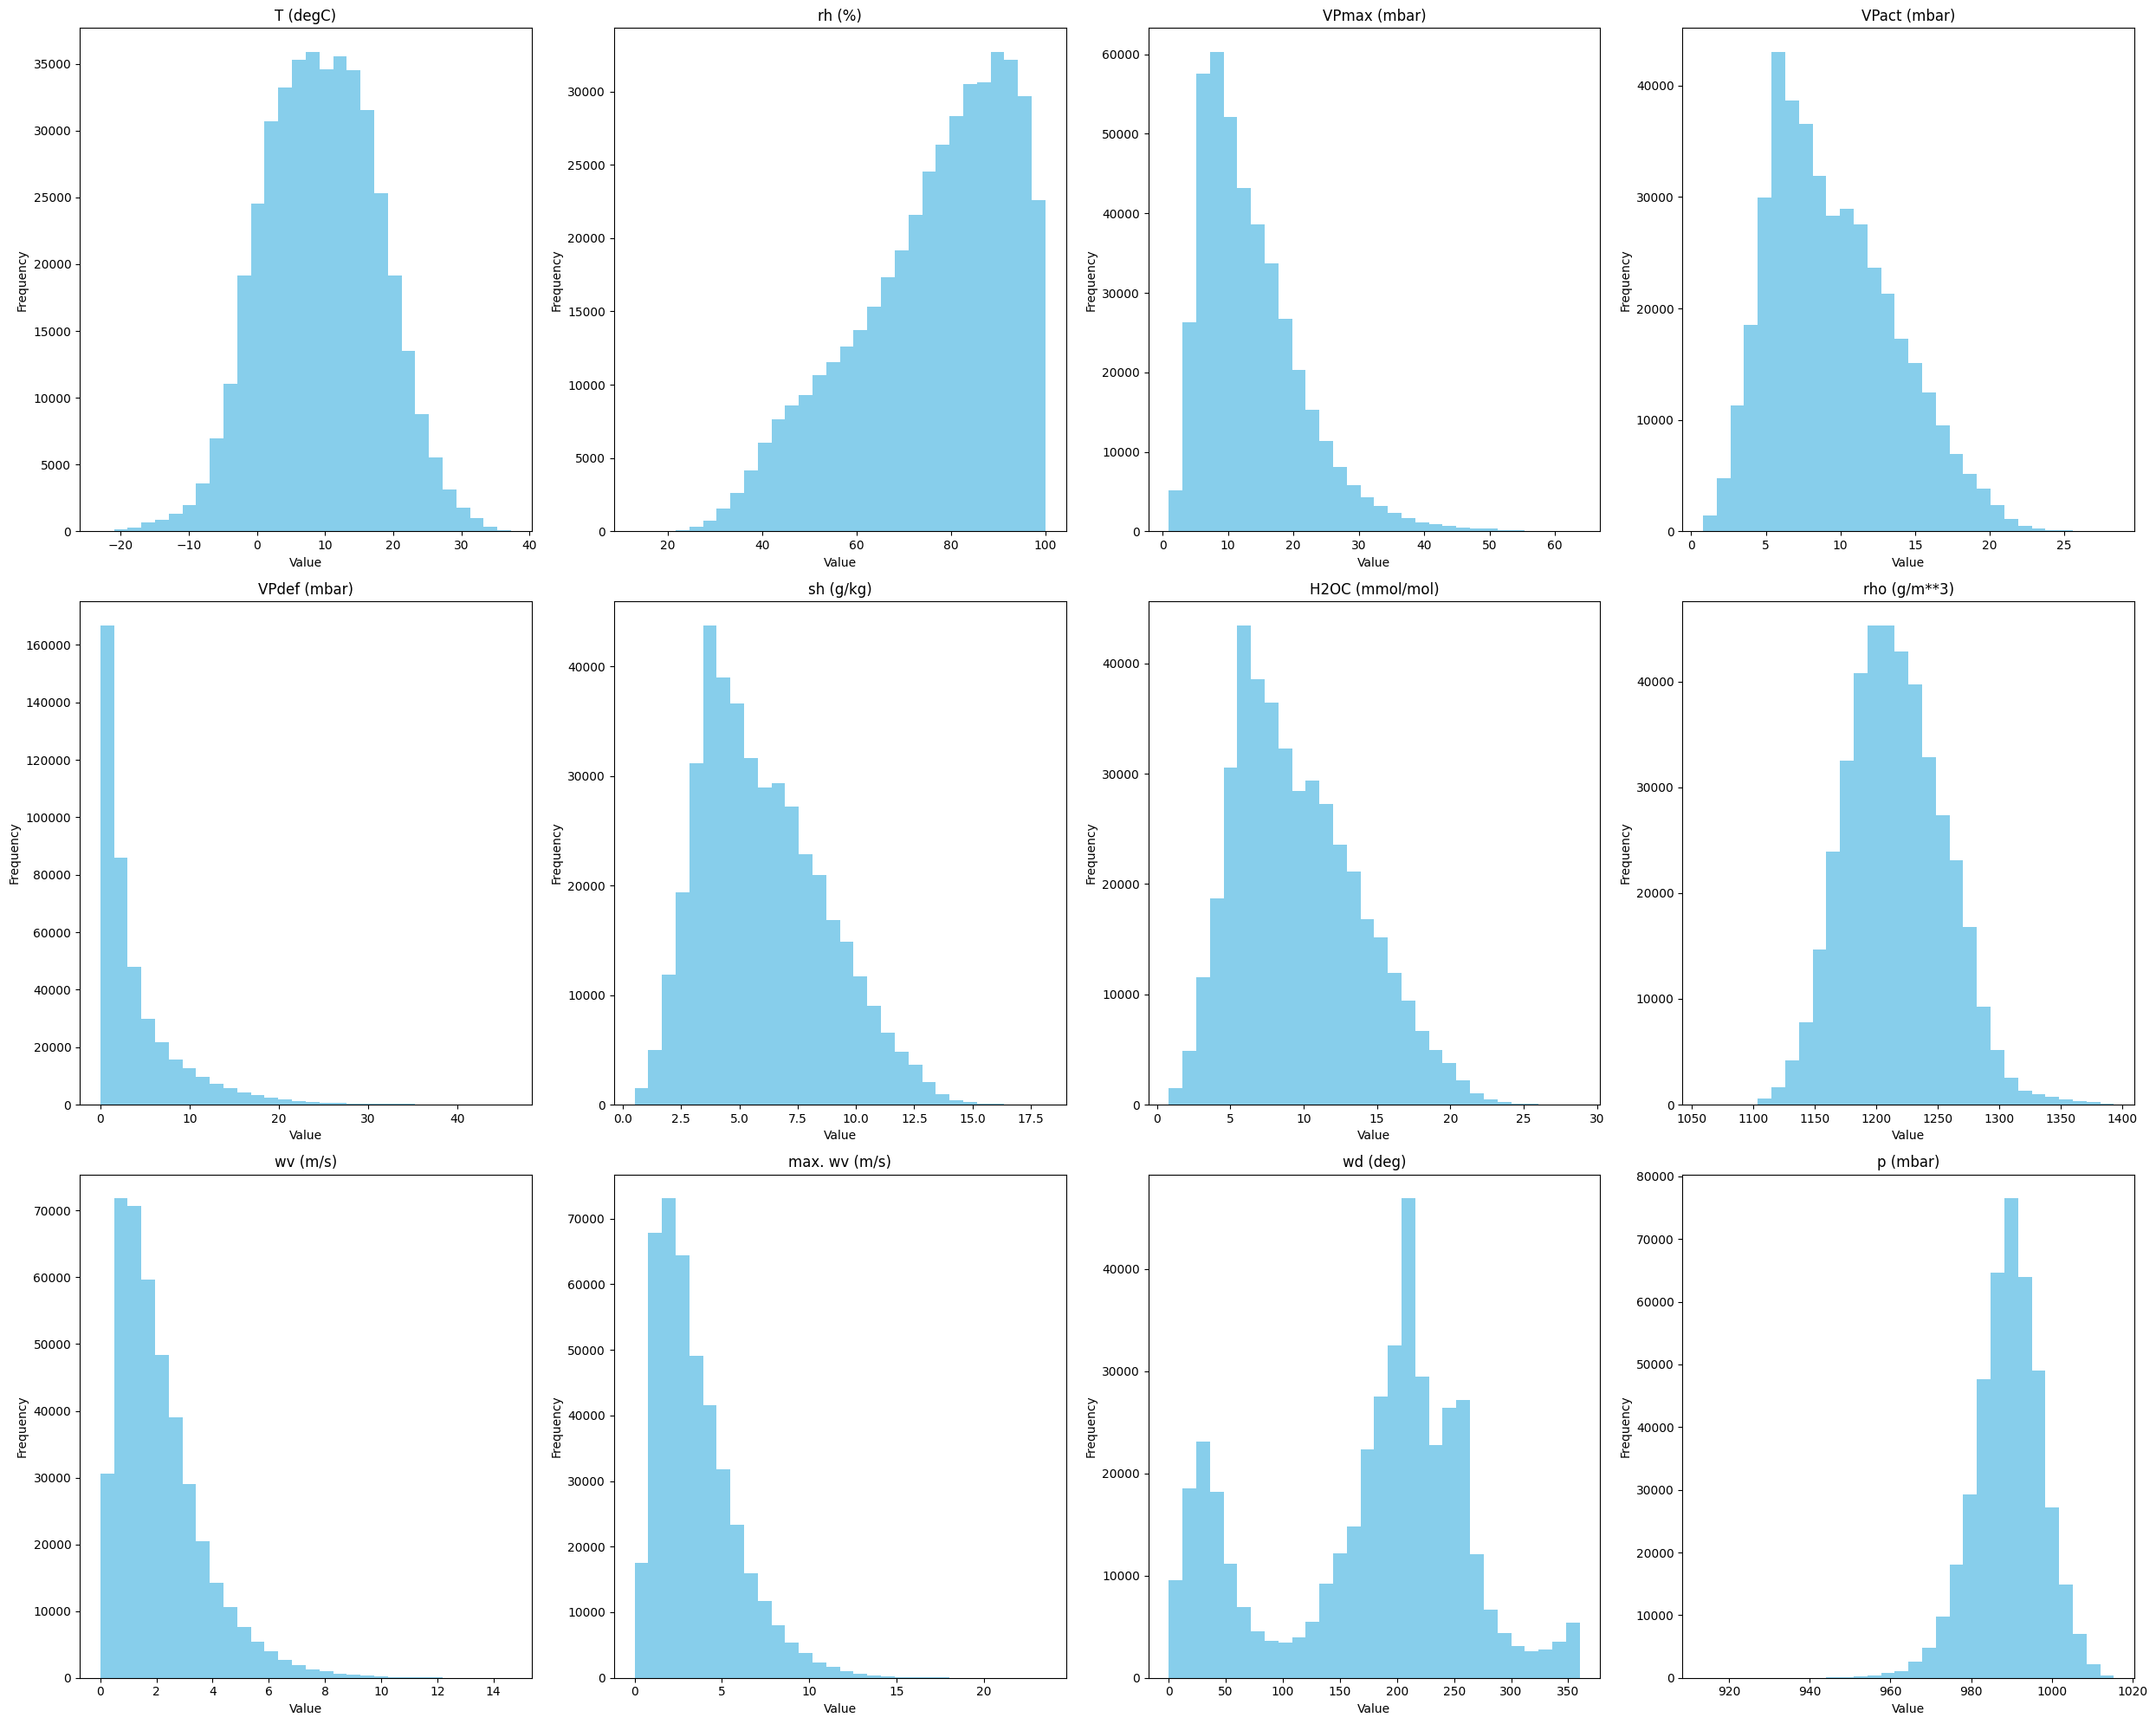

In [49]:
weather_data = pd.read_csv('FirstReportData/weather_forecast_cleaned.csv')
weather_data = weather_data.dropna()
fig, axes = plt.subplots(3, 4, figsize=(25, 20))
axes = axes.flatten()

weather_data = weather_data[weather_data['max. wv (m/s)'] != -9999]
weather_data.to_csv('FirstReportData/weather_forecast_cleaned.csv', index=False)

# print minimum wv (m/s) value
print(weather_data['wv (m/s)'].min())
print(weather_data['max. wv (m/s)'].min())

for i, column in enumerate(weather_data.columns):
    ax = axes[i]
    print(column)
    if column == 'wv (m/s)':
        ax.hist(weather_data[column], bins=30, color='skyblue')
        ax.set_title(column)
        ax.grid(False)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
    else:
        ax.hist(weather_data[column], bins=30, color='skyblue')
        ax.set_title(column)
        ax.grid(False)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')


plt.tight_layout()
plt.show()

In [51]:
# count the number of each class in urban sound 8k
metadata = pd.read_csv('FirstReportData/UrbanSound8K.csv')
metadata['class'].value_counts()

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64